# In class exercises for ML tutorials

## Read in data from eeg study
* This time I've kept in data across a 1s window from many electrodes (20) sampled at 250Hz, so now we have a [960, 20, 250] matrix that contains data from all 960 trials, 20 electrodes, and over a 1s window following stimulus onset
* Also read in a "cond_labels" vector that has 960 0's and 1's to mark trials from the two experimental conditions 

## import stuff...

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Font for figures
figureFont = {"fontname": "Arial", "size":"20"}

# Support vector classifier
from sklearn.svm import SVC 

In [3]:
# load the data...
eeg = np.load('class_demo_eeg.npz')

# get the different arrays like this...
eeg['data']
eeg['sr']
eeg['tx']
eeg['cond_labels']

# shape of data
print('Shape of the big eeg data set: ', eeg['data'].shape)

# and if you want to save some typing, especially because we only 
# have a few variables, you reassign the different arrays like this
data = eeg['data']
sr = eeg['sr']
tx = eeg['tx']
condLabels = eeg['cond_labels']

print("\nFor each of",data.shape[0],"trials, there are",data.shape[1],
     "electrodes collecting",data.shape[2],"values within 1 sec")

Shape of the big eeg data set:  (960, 20, 250)

For each of 960 trials, there are 20 electrodes collecting 250 values within 1 sec


## Compute the mean across the first dimension (trials) and then plot the mean response across time in each of the 20 electrodes on one axis

* Might need to transpose the data into a Time x Electrode format

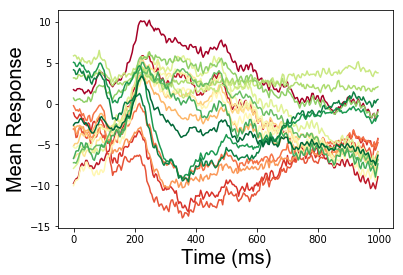

What a pretty plot, very nice colors :)


In [4]:
# Get the mean across trials (axis = 0)
meanAcrossTrials = np.mean(data, axis = 0)

# Create color map to make plot prettier
n = 20 # n colors
colors = plt.cm.RdYlGn(np.linspace(0,1,n))

# Plot mean response over time for each electrode
for i in range(n): # get new color for each line using colormap above
    plt.plot(tx, meanAcrossTrials.T[:,i], color=colors[i])
plt.xlabel("Time (ms)", **figureFont)
plt.ylabel("Mean Response", **figureFont)
plt.show()

print("What a pretty plot, very nice colors :)")

## That gives you an idea about what the pattern of data looks like across electrodes. 
* Next, take the mean across time, so you have a 960 x 20 matrix 
* Use the cond_labels vector to sort the data based on condition (so you have two 480 x 20 matrices)
* Do classification to see if you can decode the experimental condition
* Remember - break up your data into independent training and testing sets
* Set C to a small number if this is taking a long time...

In [13]:
# Get the mean across time (axis = 2)
meanAcrossTime = np.mean(data, axis = 2)

# Pull out conditions
meanAcrossTimeCond0 = meanAcrossTime[condLabels == 0]
meanAcrossTimeCond1 = meanAcrossTime[condLabels == 1]

# Just to double-check...
print("The shape of condition 0 is",meanAcrossTimeCond0.shape)
print("The shape of condition 1 is",meanAcrossTimeCond1.shape)

# How much data in training dataset?
percentTraining = 0.90

# Calculate the actual number using the percentage above
lengthTrainingSet = int(percentTraining * meanAcrossTimeCond0.shape[0])

# Pull out first 90% of each condition for training data
trainingData = np.vstack((meanAcrossTimeCond0[0:lengthTrainingSet,:],
                          meanAcrossTimeCond1[0:lengthTrainingSet,:]))

# Pull out last 10% of each condition for test data
testData = np.vstack((meanAcrossTimeCond0[lengthTrainingSet:,:],
                      meanAcrossTimeCond1[lengthTrainingSet:,:]))

# Make new labels for the training dataset
trainingLabels = np.hstack((np.zeros(lengthTrainingSet), 
                            np.ones(lengthTrainingSet)))

# Make new labels for test dataset
lengthTestSet = len(meanAcrossTimeCond0) - lengthTrainingSet

testLabels = np.hstack((np.zeros(lengthTestSet),
                        np.ones(lengthTestSet)))

# Train the model
model = SVC(kernel = "linear", C = 1)
model.fit(trainingData, trainingLabels)

# Now we classify the test trials using the model
classifiedLabels = model.predict(testData)

# And now we check our accuracy!
classificationAccuracy = np.sum(classifiedLabels == testLabels) / len(classifiedLabels)

print("\nClassification accuracy:",
      np.round(classificationAccuracy, decimals = 2))

The shape of condition 0 is (480, 20)
The shape of condition 1 is (480, 20)

Classification accuracy: 0.55


## Now try doing this across timepoints!
* First do a time window based on where you think there is nice separation in the responses across electrodes (look at the data that you plotted above)...maybe try 300-400msec post stim
* Then you can try timepoint x timepoint or a moving window

In [19]:
# Create a time window from 300-400ms
timeWindow = (tx >= 300) & (tx < 400)

# Pull out only those data within the window
dataWindow = data[:,:,timeWindow]

# Get the mean across timepoints
dataWindowMean = np.mean(dataWindow, axis = 2)

print(dataWindowMean.shape)

(960, 20)


## Bonus - try using randomization testing to eval significance